In [3]:
import pandas as pd
import numpy as np
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [4]:
#data loading
data = pd.read_csv('./kaggle/application_train.csv')
bureau = pd.read_csv('./kaggle/bureau.csv')
bureau_balance = pd.read_csv('./kaggle/bureau_balance.csv')
installments_payments = pd.read_csv('./kaggle/installments_payments.csv')
credit_card_balance = pd.read_csv('./kaggle/credit_card_balance.csv')
pos_cash_balance = pd.read_csv('./kaggle/POS_CASH_balance.csv')
previous_application = pd.read_csv('./kaggle/previous_application.csv')

In [5]:
#features preparing
bureau_balance["DPD"] = pd.to_numeric(bureau_balance["STATUS"], errors = 'coerce').fillna(0)
bureau_balance_grouped = bureau_balance.groupby("SK_ID_BUREAU").agg(
    MONTHS_BALANCE_MIN=('MONTHS_BALANCE', 'min'),
    DPD_MAX=('DPD', 'max'),
    DPD_MEAN=('DPD', 'mean'))
bureau_merged = pd.merge(bureau, bureau_balance_grouped, left_on = "SK_ID_BUREAU", right_index = True)
bureau_merged['ACTIVE'] = bureau_merged['CREDIT_ACTIVE'] == 'Active'
bureau_merged['CLOSED'] = bureau_merged['CREDIT_ACTIVE'] != 'Closed'
bureau_merged['OTHER_CURRENCY'] = bureau_merged['CREDIT_CURRENCY'] != 'currency 1'
bureau_merged['CONSUMER_CREDIT'] = ~bureau_merged['CREDIT_TYPE'].isin(('Credit card', 'Car loan', 'Mortgage'))
bureau_merged['CREDIT_CARD'] = bureau_merged['CREDIT_TYPE'] == 'Credit card'
bureau_merged['CAR_LOAN'] = bureau_merged['CREDIT_TYPE'] == 'Car loan'
bureau_merged['MORTGAGE'] = bureau_merged['CREDIT_TYPE'] == 'Mortgage'
bureau_grouped = bureau_merged.groupby("SK_ID_CURR").agg(
    CREDIT_COUNT = ('SK_ID_BUREAU', 'count'),
    DAYS_CREDIT_MAX = ('DAYS_CREDIT', 'max'),
    DAYS_CREDIT_MIN = ('DAYS_CREDIT', 'min'),
    DAYS_CREDIT_ENDDATE_MAX = ('DAYS_CREDIT_ENDDATE', 'max'),
    DAYS_CREDIT_ENDDATE_MIN = ('DAYS_CREDIT_ENDDATE', 'min'),
    DAYS_ENDDATE_FACT_MAX = ('DAYS_ENDDATE_FACT', 'max'),
    DAYS_ENDDATE_FACT_MIN = ('DAYS_ENDDATE_FACT', 'min'),
    CREDIT_DAY_OVERDUE_MAX = ('CREDIT_DAY_OVERDUE', 'max'),
    CREDIT_DAY_OVERDUE_MIN = ('CREDIT_DAY_OVERDUE', 'min'),
    AMT_CREDIT_MAX_OVERDUE_MAX = ('AMT_CREDIT_MAX_OVERDUE', 'max'),
    AMT_CREDIT_MAX_OVERDUE_MIN = ('AMT_CREDIT_MAX_OVERDUE', 'min'),
    CNT_CREDIT_PROLONG_SUM = ('CNT_CREDIT_PROLONG', 'sum'),
    CNT_CREDIT_PROLONG_MAX = ('CNT_CREDIT_PROLONG', 'max'),
    AMT_CREDIT_SUM_SUM = ('AMT_CREDIT_SUM', 'sum'),
    AMT_CREDIT_SUM_MAX = ('AMT_CREDIT_SUM', 'max'),
    AMT_CREDIT_SUM_MIN = ('AMT_CREDIT_SUM', 'min'),
    AMT_CREDIT_SUM_DEBT_SUM = ('AMT_CREDIT_SUM_DEBT', 'sum'),
    AMT_CREDIT_SUM_DEBT_MAX = ('AMT_CREDIT_SUM_DEBT', 'max'),
    AMT_CREDIT_SUM_LIMIT_SUM = ('AMT_CREDIT_SUM_LIMIT', 'sum'),
    AMT_CREDIT_SUM_LIMIT_MAX = ('AMT_CREDIT_SUM_LIMIT', 'max'),
    AMT_CREDIT_SUM_OVERDUE_SUM = ('AMT_CREDIT_SUM_OVERDUE', 'sum'),
    AMT_CREDIT_SUM_OVERDUE_MAX = ('AMT_CREDIT_SUM_OVERDUE', 'max'),
    DAYS_CREDIT_UPDATE_MIN = ('DAYS_CREDIT_UPDATE', 'min'),
    DAYS_CREDIT_UPDATE_MEAN = ('DAYS_CREDIT_UPDATE', 'mean'),
    AMT_ANNUITY_MAX = ('AMT_ANNUITY', 'max'),
    AMT_ANNUITY_MEAN = ('AMT_ANNUITY', 'mean'),
    MONTHS_BALANCE_MIN=('MONTHS_BALANCE_MIN', 'min'),
    DPD_MAX_MAX=('DPD_MAX', 'max'),
    DPD_MAX_MEAN=('DPD_MAX', 'mean'),
    DPD_MEAN_MAX=('DPD_MEAN', 'max'),
    ACTIVE_COUNT=('ACTIVE', 'sum'),
    CLOSED_COUNT=('CLOSED', 'sum'),
    OTHER_CURRENCY_COUNT=('OTHER_CURRENCY', 'sum'),
    CONSUMER_CREDIT_COUNT =('CONSUMER_CREDIT', 'sum'),
    CREDIT_CARD_COUNT =('CREDIT_CARD', 'sum'),
    CAR_LOAN_COUNT =('CAR_LOAN', 'sum'),
    MORTGAGE_COUNT =('MORTGAGE', 'sum'),
)
installments_payments['DAYS_DIFF'] = installments_payments['DAYS_INSTALMENT']-installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['AMT_DIFF'] = installments_payments['AMT_INSTALMENT']-installments_payments['AMT_PAYMENT']
installments_payments_grouped = installments_payments.groupby("SK_ID_CURR").agg(
    NUM_INSTALMENT_VERSION_MAX=('NUM_INSTALMENT_VERSION', 'max'),
    AMT_PAYMENT_MAX=('AMT_PAYMENT', 'max'),
    AMT_INSTALMENT_MAX=('AMT_INSTALMENT', 'max'),
    DAYS_DIFF_MAX=('DAYS_DIFF', 'max'),
    DAYS_DIFF_MIN=('DAYS_DIFF', 'min'),
    DAYS_DIFF_MEAN=('DAYS_DIFF', 'mean'),
    AMT_DIFF_MAX=('AMT_DIFF', 'max'),
    AMT_DIFF_MIN=('AMT_DIFF', 'min'),
    AMT_DIFF_MEAN=('AMT_DIFF', 'mean'),
    AMT_DIFF_SUM=('AMT_DIFF', 'sum'),
)
credit_card_balance_grouped = credit_card_balance.groupby("SK_ID_CURR").agg(
    MONTHS_BALANCE_MIN=('MONTHS_BALANCE', 'min'),
    AMT_BALANCE_MIN=('AMT_BALANCE', 'min'),
    AMT_BALANCE_MAX=('AMT_BALANCE', 'max'),
    AMT_BALANCE_MEAN=('AMT_BALANCE', 'mean'),
    AMT_CREDIT_LIMIT_ACTUAL_MIN=('AMT_CREDIT_LIMIT_ACTUAL', 'min'),
    AMT_CREDIT_LIMIT_ACTUAL_MAX=('AMT_CREDIT_LIMIT_ACTUAL', 'max'),
    AMT_DRAWINGS_ATM_CURRENT_MAX=('AMT_DRAWINGS_ATM_CURRENT', 'max'),
    AMT_DRAWINGS_CURRENT_MAX=('AMT_DRAWINGS_CURRENT', 'max'),
    AMT_DRAWINGS_OTHER_CURRENT_MAX=('AMT_DRAWINGS_OTHER_CURRENT', 'max'),
    AMT_DRAWINGS_POS_CURRENT_MAX=('AMT_DRAWINGS_POS_CURRENT', 'max'),
    AMT_INST_MIN_REGULARITY_MAX=('AMT_INST_MIN_REGULARITY', 'max'),
    AMT_INST_MIN_REGULARITY_MEAN=('AMT_INST_MIN_REGULARITY', 'mean'),
    AMT_PAYMENT_CURRENT_MAX=('AMT_PAYMENT_CURRENT', 'max'),
    AMT_PAYMENT_CURRENT_MEAN=('AMT_PAYMENT_CURRENT', 'mean'),
    AMT_RECEIVABLE_PRINCIPAL_MAX=('AMT_RECEIVABLE_PRINCIPAL', 'max'),
    AMT_RECEIVABLE_PRINCIPAL_MEAN=('AMT_RECEIVABLE_PRINCIPAL', 'mean'),
    AMT_RECIVABLE_MAX=('AMT_RECIVABLE', 'max'),
    AMT_RECIVABLE_MEAN=('AMT_RECIVABLE', 'max'),
    CNT_DRAWINGS_ATM_CURRENT_MAX=('CNT_DRAWINGS_ATM_CURRENT', 'max'),
    CNT_DRAWINGS_ATM_CURRENT_MEAN=('CNT_DRAWINGS_ATM_CURRENT', 'mean'),
    CNT_DRAWINGS_CURRENT_MAX=('CNT_DRAWINGS_CURRENT', 'max'),
    CNT_DRAWINGS_CURRENT_MEAN=('CNT_DRAWINGS_CURRENT', 'mean'),
    CNT_DRAWINGS_OTHER_CURRENT_MAX=('CNT_DRAWINGS_OTHER_CURRENT', 'max'),
    CNT_DRAWINGS_OTHER_CURRENT_MEAN=('CNT_DRAWINGS_OTHER_CURRENT', 'mean'),
    CNT_DRAWINGS_POS_CURRENT_MAX=('CNT_DRAWINGS_POS_CURRENT', 'max'),
    CNT_DRAWINGS_POS_CURRENT_MEAN=('CNT_DRAWINGS_POS_CURRENT', 'mean'),
    CNT_INSTALMENT_MATURE_CUM_MAX=('CNT_INSTALMENT_MATURE_CUM', 'max'),
    CNT_INSTALMENT_MATURE_CUM_MEAN=('CNT_INSTALMENT_MATURE_CUM', 'mean'),
    SK_DPD_MAX=('SK_DPD', 'max'),
    SK_DPD_DEF_MAX=('SK_DPD_DEF', 'max')
)
pos_cash_balance_grouped = pos_cash_balance.groupby("SK_ID_CURR").agg(
    MONTHS_BALANCE_MIN=('MONTHS_BALANCE', 'min'),
    SK_DPD_MAX=('SK_DPD', 'max'),
    SK_DPD_DEF_MAX=('SK_DPD_DEF', 'max'),
)
previous_application['CONTRACT_TYPE_CASH'] = previous_application['NAME_CONTRACT_TYPE'] == 'Cash loans'
previous_application['CONTRACT_TYPE_CONSUMER'] = previous_application['NAME_CONTRACT_TYPE'] == 'Consumer loans'
previous_application['CONTRACT_TYPE_REVOLVING'] = previous_application['NAME_CONTRACT_TYPE'] == 'Revolving loans'
previous_application['CONTRACT_STATUS_APPROVED'] = previous_application['NAME_CONTRACT_STATUS'] == 'Approved'
previous_application['CONTRACT_STATUS_CANCELED'] = previous_application['NAME_CONTRACT_STATUS'].isin(('Canceled', 
                                                                                                      'Unused offer'))
previous_application['CONTRACT_STATUS_REFUSED'] = previous_application['NAME_CONTRACT_STATUS'] == 'Refused'
previous_application['REJECT_REASON_HC'] = previous_application['CODE_REJECT_REASON'] == 'HC'
previous_application['REJECT_REASON_LIMIT'] = previous_application['CODE_REJECT_REASON'] == 'LIMIT'
previous_application['REJECT_REASON_SCO'] = previous_application['CODE_REJECT_REASON'] == 'SCO'
previous_application['REJECT_REASON_CLIENT'] = previous_application['CODE_REJECT_REASON'] == 'CLIENT'
previous_application['REJECT_REASON_SCOFR'] = previous_application['CODE_REJECT_REASON'] == 'SCOFR'
previous_application['REJECT_REASON_VERIF'] = previous_application['CODE_REJECT_REASON'] == 'VERIF'
previous_application['TYPE_SUITE_UNACCOMPANIED'] = previous_application['NAME_TYPE_SUITE'] == 'Unaccompanied'
previous_application['TYPE_SUITE_FAMILY'] = previous_application['NAME_TYPE_SUITE'].isin(('Family', 'Spouse, partner', 'Children'))
previous_application['TYPE_SUITE'] = previous_application['NAME_TYPE_SUITE'].isin(('Other_B', 'Other_A', 'Group of people'))
previous_application['GOODS_CATEGORY_ELECTRONICS'] = previous_application['NAME_GOODS_CATEGORY'].isin(('Mobile', 
                                    'Consumer Electronics', 'Computers', 'Audio/Video', 'Photo / Cinema Equipment', ))
previous_application['GOODS_CATEGORY_HOME'] = previous_application['NAME_GOODS_CATEGORY'].isin(('Furniture', 'Construction Materials', 
                                    'Homewares', 'Gardening', 'Office Appliances', 'House Construction'))
previous_application['GOODS_CATEGORY_LIFESTYLE'] = previous_application['NAME_GOODS_CATEGORY'].isin(('Clothing and Accessories', 
                                    'Jewelry', 'Sport and Leisure', 'Tourism', 'Fitness'))
previous_application['GOODS_CATEGORY_CAR'] = previous_application['NAME_GOODS_CATEGORY'].isin(('Auto Accessories', 'Vehicles', 
                                    'Insurance'))
previous_application['PORTFOLIO_POS'] = previous_application['NAME_PORTFOLIO'] == 'POS'
previous_application['PORTFOLIO_CASH'] = previous_application['NAME_PORTFOLIO'] == 'Cash'
previous_application['PORTFOLIO_CARDS'] = previous_application['NAME_PORTFOLIO'] == 'Cards'
previous_application['PRODUCT_TYPE_XSELL'] = previous_application['NAME_PRODUCT_TYPE'] == 'x-sell'
previous_application['PRODUCT_TYPE_WALKIN'] = previous_application['NAME_PRODUCT_TYPE'] == 'walk-in'
previous_application['YIELD_GROUP_MIDDLE'] = previous_application['NAME_YIELD_GROUP'] == 'middle'
previous_application['YIELD_GROUP_HIGH'] = previous_application['NAME_YIELD_GROUP'] == 'high'
previous_application['YIELD_GROUP_LOW_NORMAL'] = previous_application['NAME_YIELD_GROUP'] == 'low_normal'
previous_application['YIELD_GROUP_LOW_ACTION'] = previous_application['NAME_YIELD_GROUP'] == 'low_action'
previous_application_grouped = previous_application.groupby("SK_ID_CURR").agg(
    AMT_ANNUITY_MIN=('AMT_ANNUITY', 'min'),
    AMT_ANNUITY_MAX=('AMT_ANNUITY', 'max'),
    AMT_ANNUITY_MEAN=('AMT_ANNUITY', 'mean'),
    AMT_APPLICATION_MIN=('AMT_APPLICATION', 'min'),
    AMT_APPLICATION_MAX=('AMT_APPLICATION', 'max'),
    AMT_APPLICATION_MEAN=('AMT_APPLICATION', 'mean'),
    AMT_CREDIT_MIN=('AMT_CREDIT', 'min'),
    AMT_CREDIT_MAX=('AMT_CREDIT', 'max'),
    AMT_CREDIT_MEAN=('AMT_CREDIT', 'mean'),
    AMT_DOWN_PAYMENT_MIN=('AMT_DOWN_PAYMENT', 'min'),
    AMT_DOWN_PAYMENT_MAX=('AMT_DOWN_PAYMENT', 'max'),
    AMT_DOWN_PAYMENT_MEAN=('AMT_DOWN_PAYMENT', 'mean'),
    AMT_GOODS_PRICE_MIN=('AMT_GOODS_PRICE', 'min'),
    AMT_GOODS_PRICE_MAX=('AMT_GOODS_PRICE', 'max'),
    AMT_GOODS_PRICE_MEAN=('AMT_GOODS_PRICE', 'mean'),
    RATE_DOWN_PAYMENT_MIN=('RATE_DOWN_PAYMENT', 'min'),
    RATE_DOWN_PAYMENT_MAX=('RATE_DOWN_PAYMENT', 'max'),
    RATE_DOWN_PAYMENT_MEAN=('RATE_DOWN_PAYMENT', 'mean'),
    RATE_INTEREST_PRIMARY_MIN=('RATE_INTEREST_PRIMARY', 'min'),
    RATE_INTEREST_PRIMARY_MAX=('RATE_INTEREST_PRIMARY', 'max'),
    RATE_INTEREST_PRIMARY_MEAN=('RATE_INTEREST_PRIMARY', 'mean'),
    RATE_INTEREST_PRIVILEGED_MIN=('RATE_INTEREST_PRIVILEGED', 'min'),
    RATE_INTEREST_PRIVILEGED_MAX=('RATE_INTEREST_PRIVILEGED', 'max'),
    RATE_INTEREST_PRIVILEGED_MEAN=('RATE_INTEREST_PRIVILEGED', 'mean'),
    DAYS_DECISION_MAX=('DAYS_DECISION', 'max'),
    DAYS_DECISION_MIN=('DAYS_DECISION', 'min'),
    CNT_PAYMENT_MAX=('CNT_PAYMENT', 'max'),
    CNT_PAYMENT_MIN=('CNT_PAYMENT', 'min'),
    CNT_PAYMENT_MEAN=('CNT_PAYMENT', 'mean'),
    DAYS_FIRST_DRAWING_MAX=('DAYS_FIRST_DRAWING', 'max'),
    DAYS_FIRST_DRAWING_MIN=('DAYS_FIRST_DRAWING', 'min'),
    DAYS_FIRST_DUE_MAX=('DAYS_FIRST_DUE', 'max'),
    DAYS_FIRST_DUE_MIN=('DAYS_FIRST_DUE', 'min'),
    DAYS_LAST_DUE_1ST_VERSION_MAX=('DAYS_LAST_DUE_1ST_VERSION', 'max'),
    DAYS_LAST_DUE_1ST_VERSION_MIN=('DAYS_LAST_DUE_1ST_VERSION', 'min'),
    DAYS_LAST_DUE_MAX=('DAYS_LAST_DUE', 'max'),
    DAYS_LAST_DUE_MIN=('DAYS_LAST_DUE', 'min'),
    DAYS_TERMINATION_MAX=('DAYS_TERMINATION', 'max'),
    DAYS_TERMINATION_MIN=('DAYS_TERMINATION', 'min'),
    NFLAG_INSURED_ON_APPROVAL_SUM=('NFLAG_INSURED_ON_APPROVAL', 'sum'),
    CONTRACT_TYPE_CASH_SUM=('CONTRACT_TYPE_CASH', 'sum'),
    CONTRACT_TYPE_CONSUMER_SUM=('CONTRACT_TYPE_CONSUMER', 'sum'),
    CONTRACT_TYPE_REVOLVING_SUM=('CONTRACT_TYPE_REVOLVING', 'sum'),
    CONTRACT_STATUS_APPROVED_SUM=('CONTRACT_STATUS_APPROVED', 'sum'),
    CONTRACT_STATUS_CANCELED_SUM=('CONTRACT_STATUS_CANCELED', 'sum'),
    CONTRACT_STATUS_REFUSED_SUM=('CONTRACT_STATUS_REFUSED', 'sum'),
    REJECT_REASON_HC_SUM=('REJECT_REASON_HC', 'sum'),
    REJECT_REASON_LIMIT_SUM=('REJECT_REASON_LIMIT', 'sum'),
    REJECT_REASON_SCO_SUM=('REJECT_REASON_SCO', 'sum'),
    REJECT_REASON_CLIENT_SUM=('REJECT_REASON_CLIENT', 'sum'),
    REJECT_REASON_SCOFR_SUM=('REJECT_REASON_SCOFR', 'sum'),
    REJECT_REASON_VERIF_SUM=('REJECT_REASON_VERIF', 'sum'),
    TYPE_SUITE_UNACCOMPANIED_SUM=('TYPE_SUITE_UNACCOMPANIED', 'sum'),
    TYPE_SUITE_FAMILY_SUM=('TYPE_SUITE_FAMILY', 'sum'),
    TYPE_SUITE_SUM=('TYPE_SUITE', 'sum'),
    GOODS_CATEGORY_ELECTRONICS_SUM=('GOODS_CATEGORY_ELECTRONICS', 'sum'),
    GOODS_CATEGORY_HOME_SUM=('GOODS_CATEGORY_HOME', 'sum'),
    GOODS_CATEGORY_LIFESTYLE_SUM=('GOODS_CATEGORY_LIFESTYLE', 'sum'),
    GOODS_CATEGORY_CAR_SUM=('GOODS_CATEGORY_CAR', 'sum'),
    PORTFOLIO_POS_SUM=('PORTFOLIO_POS', 'sum'),
    PORTFOLIO_CASH_SUM=('PORTFOLIO_CASH', 'sum'),
    PORTFOLIO_CARDS_SUM=('PORTFOLIO_CARDS', 'sum'),
    PRODUCT_TYPE_XSELL_SUM=('PRODUCT_TYPE_XSELL', 'sum'),
    PRODUCT_TYPE_WALKIN_SUM=('PRODUCT_TYPE_WALKIN', 'sum'),
    YIELD_GROUP_MIDDLE_SUM=('YIELD_GROUP_MIDDLE', 'sum'),
    YIELD_GROUP_HIGH_SUM=('YIELD_GROUP_HIGH', 'sum'),
    YIELD_GROUP_LOW_NORMAL_SUM=('YIELD_GROUP_LOW_NORMAL', 'sum'),
    YIELD_GROUP_LOW_ACTION_SUM=('YIELD_GROUP_LOW_ACTION', 'sum'),
)
data_merged = data.merge(bureau_grouped, left_on = "SK_ID_CURR", right_index = True, how = 'left', suffixes = ('', "_BUREAU"))\
    .merge(installments_payments_grouped, left_on = "SK_ID_CURR", right_index = True, how = 'left', suffixes = ('', "_INSTALLMENTS"))\
    .merge(credit_card_balance_grouped, left_on = "SK_ID_CURR", right_index = True, how = 'left', suffixes = ('', "_CC"))\
    .merge(pos_cash_balance_grouped, left_on = "SK_ID_CURR", right_index = True, how = 'left', suffixes = ('', "_POS"))\
    .merge(previous_application_grouped, left_on = "SK_ID_CURR", right_index = True, how = 'left', suffixes = ('', "_PREVIOUS"))

In [7]:
# data splitting
y = data_merged['TARGET']
X = data_merged.drop(['SK_ID_CURR','TARGET'], axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)
# dealing with categorical features
categorical_features = list(X_train.select_dtypes(include=['object']).columns)
X_train[categorical_features] = X_train[categorical_features].fillna('')
X_test[categorical_features] = X_test[categorical_features].fillna('')

In [8]:
# feature selection
model = CatBoostClassifier()
summary = model.select_features(X_train.drop(categorical_features, axis=1), 
                      y_train, 
                      features_for_select = X_train.drop(categorical_features, axis=1).columns, 
                      num_features_to_select = 30,
                      steps=3)

Learning rate set to 0.108111
Step #1 out of 3
0:	learn: 0.5897159	total: 127ms	remaining: 2m 7s
1:	learn: 0.5039948	total: 166ms	remaining: 1m 22s
2:	learn: 0.4445486	total: 210ms	remaining: 1m 9s
3:	learn: 0.4025223	total: 255ms	remaining: 1m 3s
4:	learn: 0.3680859	total: 298ms	remaining: 59.4s
5:	learn: 0.3453056	total: 342ms	remaining: 56.7s
6:	learn: 0.3262430	total: 386ms	remaining: 54.8s
7:	learn: 0.3119435	total: 424ms	remaining: 52.5s
8:	learn: 0.2994074	total: 468ms	remaining: 51.5s
9:	learn: 0.2903245	total: 511ms	remaining: 50.6s
10:	learn: 0.2826948	total: 553ms	remaining: 49.8s
11:	learn: 0.2768641	total: 597ms	remaining: 49.1s
12:	learn: 0.2721686	total: 645ms	remaining: 49s
13:	learn: 0.2687227	total: 698ms	remaining: 49.2s
14:	learn: 0.2656081	total: 746ms	remaining: 49s
15:	learn: 0.2631793	total: 803ms	remaining: 49.4s
16:	learn: 0.2614810	total: 842ms	remaining: 48.7s
17:	learn: 0.2599257	total: 887ms	remaining: 48.4s
18:	learn: 0.2584869	total: 979ms	remaining: 50.

In [10]:
# hyperparameter training
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_train[summary['selected_features_names']], 
                                                          y_train, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.6, log=True),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "random_strength" : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "od_type" : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait" : trial.suggest_int("od_wait", 10, 50),

    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],  verbose=0, 
            early_stopping_rounds=250)

    preds = gbm.predict_proba(valid_x)
    return roc_auc_score(valid_y, preds[:,1])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=250)

[I 2024-05-12 23:21:25,350] A new study created in memory with name: no-name-8ba4f790-b3fa-4ee0-8a91-4dea1c390c4e
[I 2024-05-12 23:21:39,110] Trial 0 finished with value: 0.710099713205171 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.011203994394747053, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'n_estimators': 902, 'learning_rate': 0.00109676253374602, 'l2_leaf_reg': 3.111701494220873e-05, 'random_strength': 9.773060508235752e-06, 'od_type': 'Iter', 'od_wait': 13, 'subsample': 0.6767259656380213}. Best is trial 0 with value: 0.710099713205171.
[I 2024-05-12 23:21:41,191] Trial 1 finished with value: 0.7184503286574551 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07817514672737211, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'n_estimators': 363, 'learning_rate': 0.004617097849882283, 'l2_leaf_reg': 1.165609608023496e-05, 'random_strength': 4.356623129980667e-06, 'od_type': 'Iter', 'od_wa

In [12]:
# model training
model_hyperparams = CatBoostClassifier(objective = 'CrossEntropy', 
                                       colsample_bylevel = 0.05263828508107553, 
                                       depth = 7, 
                                       boosting_type = 'Ordered', 
                                       bootstrap_type = 'MVS', 
                                       n_estimators = 494, 
                                       learning_rate = 0.19127093478997848, 
                                       l2_leaf_reg = 22.675416875398728, 
                                       random_strength = 2.43380442006476e-08, 
                                       od_type = 'IncToDec', 
                                       od_wait = 34)
model_hyperparams.fit(X_train[summary['selected_features_names']], 
                      y_train)

0:	learn: 0.5219856	total: 25.1ms	remaining: 12.4s
1:	learn: 0.4242052	total: 63.5ms	remaining: 15.6s
2:	learn: 0.3644368	total: 114ms	remaining: 18.7s
3:	learn: 0.3219808	total: 143ms	remaining: 17.5s
4:	learn: 0.3011429	total: 173ms	remaining: 16.9s
5:	learn: 0.2894601	total: 193ms	remaining: 15.7s
6:	learn: 0.2818858	total: 219ms	remaining: 15.2s
7:	learn: 0.2763500	total: 255ms	remaining: 15.5s
8:	learn: 0.2706485	total: 296ms	remaining: 15.9s
9:	learn: 0.2690700	total: 331ms	remaining: 16s
10:	learn: 0.2666683	total: 368ms	remaining: 16.1s
11:	learn: 0.2660889	total: 387ms	remaining: 15.5s
12:	learn: 0.2625918	total: 422ms	remaining: 15.6s
13:	learn: 0.2611092	total: 453ms	remaining: 15.5s
14:	learn: 0.2596889	total: 479ms	remaining: 15.3s
15:	learn: 0.2596294	total: 498ms	remaining: 14.9s
16:	learn: 0.2583756	total: 524ms	remaining: 14.7s
17:	learn: 0.2574298	total: 553ms	remaining: 14.6s
18:	learn: 0.2570898	total: 583ms	remaining: 14.6s
19:	learn: 0.2559968	total: 619ms	remaini

In [25]:
# model scoring
y_pred_train = model_hyperparams.predict_proba(X_train[summary['selected_features_names']])
y_pred_test = model_hyperparams.predict_proba(X_test[summary['selected_features_names']])

In [13]:
summary['selected_features_names']

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'DAYS_CREDIT_MAX',
 'AMT_INSTALMENT_MAX',
 'DAYS_DIFF_MIN',
 'AMT_DIFF_MEAN',
 'AMT_BALANCE_MIN',
 'CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'MONTHS_BALANCE_MIN_POS',
 'AMT_ANNUITY_MEAN_PREVIOUS',
 'CNT_PAYMENT_MEAN',
 'DAYS_FIRST_DUE_MAX',
 'DAYS_LAST_DUE_1ST_VERSION_MAX',
 'DAYS_LAST_DUE_MAX',
 'CONTRACT_STATUS_APPROVED_SUM',
 'CONTRACT_STATUS_REFUSED_SUM',
 'YIELD_GROUP_HIGH_SUM']

In [24]:
X_train['SEG_1'] = X_train['CODE_GENDER'] == "M"
X_test['SEG_1'] = X_test['CODE_GENDER'] == "M"
X_train['SEG_2'] = X_train['FLAG_OWN_CAR'] == "Y"
X_test['SEG_2'] = X_test['FLAG_OWN_CAR'] == "Y"
X_train['SEG_3'] = X_train['FLAG_OWN_REALTY'] == "Y"
X_test['SEG_3'] = X_test['FLAG_OWN_REALTY'] == "Y"

In [30]:
X_train['FEAT_1']=X_train['AMT_INCOME_TOTAL']
X_train['FEAT_2']=X_train['AMT_CREDIT']
X_train['FEAT_3']=X_train['AMT_ANNUITY']
X_train['FEAT_4']=X_train['AMT_GOODS_PRICE']
X_train['FEAT_5']=X_train['REGION_POPULATION_RELATIVE']
X_train['FEAT_6']=X_train['DAYS_BIRTH']
X_train['FEAT_7']=X_train['DAYS_EMPLOYED']
X_train['FEAT_8']=X_train['DAYS_REGISTRATION']
X_train['FEAT_9']=X_train['DAYS_ID_PUBLISH']
X_train['FEAT_10']=X_train['OWN_CAR_AGE']
X_train['FEAT_11']=X_train['EXT_SOURCE_1']
X_train['FEAT_12']=X_train['EXT_SOURCE_2']
X_train['FEAT_13']=X_train['EXT_SOURCE_3']
X_train['FEAT_14']=X_train['DAYS_LAST_PHONE_CHANGE']
X_train['FEAT_15']=X_train['AMT_REQ_CREDIT_BUREAU_QRT']
X_train['FEAT_16']=X_train['DAYS_CREDIT_MAX']
X_train['FEAT_17']=X_train['AMT_INSTALMENT_MAX']
X_train['FEAT_18']=X_train['DAYS_DIFF_MIN']
X_train['FEAT_19']=X_train['AMT_DIFF_MEAN']
X_train['FEAT_20']=X_train['AMT_BALANCE_MIN']
X_train['FEAT_21']=X_train['CNT_DRAWINGS_ATM_CURRENT_MEAN']
X_train['FEAT_22']=X_train['MONTHS_BALANCE_MIN_POS']
X_train['FEAT_23']=X_train['AMT_ANNUITY_MEAN_PREVIOUS']
X_train['FEAT_24']=X_train['CNT_PAYMENT_MEAN']
X_train['FEAT_25']=X_train['DAYS_FIRST_DUE_MAX']
X_train['FEAT_26']=X_train['DAYS_LAST_DUE_1ST_VERSION_MAX']
X_train['FEAT_27']=X_train['DAYS_LAST_DUE_MAX']
X_train['FEAT_28']=X_train['CONTRACT_STATUS_APPROVED_SUM']
X_train['FEAT_29']=X_train['CONTRACT_STATUS_REFUSED_SUM']
X_train['FEAT_30']=X_train['YIELD_GROUP_HIGH_SUM']
X_test['FEAT_1']=X_test['AMT_INCOME_TOTAL']
X_test['FEAT_2']=X_test['AMT_CREDIT']
X_test['FEAT_3']=X_test['AMT_ANNUITY']
X_test['FEAT_4']=X_test['AMT_GOODS_PRICE']
X_test['FEAT_5']=X_test['REGION_POPULATION_RELATIVE']
X_test['FEAT_6']=X_test['DAYS_BIRTH']
X_test['FEAT_7']=X_test['DAYS_EMPLOYED']
X_test['FEAT_8']=X_test['DAYS_REGISTRATION']
X_test['FEAT_9']=X_test['DAYS_ID_PUBLISH']
X_test['FEAT_10']=X_test['OWN_CAR_AGE']
X_test['FEAT_11']=X_test['EXT_SOURCE_1']
X_test['FEAT_12']=X_test['EXT_SOURCE_2']
X_test['FEAT_13']=X_test['EXT_SOURCE_3']
X_test['FEAT_14']=X_test['DAYS_LAST_PHONE_CHANGE']
X_test['FEAT_15']=X_test['AMT_REQ_CREDIT_BUREAU_QRT']
X_test['FEAT_16']=X_test['DAYS_CREDIT_MAX']
X_test['FEAT_17']=X_test['AMT_INSTALMENT_MAX']
X_test['FEAT_18']=X_test['DAYS_DIFF_MIN']
X_test['FEAT_19']=X_test['AMT_DIFF_MEAN']
X_test['FEAT_20']=X_test['AMT_BALANCE_MIN']
X_test['FEAT_21']=X_test['CNT_DRAWINGS_ATM_CURRENT_MEAN']
X_test['FEAT_22']=X_test['MONTHS_BALANCE_MIN_POS']
X_test['FEAT_23']=X_test['AMT_ANNUITY_MEAN_PREVIOUS']
X_test['FEAT_24']=X_test['CNT_PAYMENT_MEAN']
X_test['FEAT_25']=X_test['DAYS_FIRST_DUE_MAX']
X_test['FEAT_26']=X_test['DAYS_LAST_DUE_1ST_VERSION_MAX']
X_test['FEAT_27']=X_test['DAYS_LAST_DUE_MAX']
X_test['FEAT_28']=X_test['CONTRACT_STATUS_APPROVED_SUM']
X_test['FEAT_29']=X_test['CONTRACT_STATUS_REFUSED_SUM']
X_test['FEAT_30']=X_test['YIELD_GROUP_HIGH_SUM']

In [31]:
X_train['PRED'] = y_pred_train[:,1]
X_test['PRED'] = y_pred_test[:,1]

In [32]:
X_train['TARGET'] = y_train
X_test['TARGET'] = y_test

In [33]:
masterscale = [0, 0.0001, 0.0013, 0.0017, 0.0022, 0.0029, 0.0038, 0.005, 0.0066, 0.0086, 0.0112,
0.0147, 0.0191, 0.0249, 0.0324, 0.042, 0.0544, 0.07, 0.0898, 0.1144, 0.1448, 0.1815,
0.2251, 0.2756, 1]

labels = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3',
'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'H1', 'H2', 'H3']

X_train["PRED_BINNED"] = pd.cut(X_train.PRED, masterscale, labels = labels)
X_test["PRED_BINNED"] = pd.cut(X_test.PRED, masterscale, labels = labels)

In [35]:
X_train_kaggle = X_train[["PRED", "PRED_BINNED", "TARGET", "SEG_1", "SEG_2", "SEG_3", 
                          "FEAT_1", "FEAT_2", "FEAT_3", "FEAT_4", "FEAT_5", "FEAT_6", "FEAT_7", "FEAT_8", "FEAT_9", "FEAT_10", 
                          "FEAT_11", "FEAT_12", "FEAT_13", "FEAT_14", "FEAT_15", "FEAT_16", "FEAT_17", "FEAT_18", "FEAT_19", "FEAT_20",
                          "FEAT_21", "FEAT_22", "FEAT_23", "FEAT_24", "FEAT_25", "FEAT_26", "FEAT_27", "FEAT_28", "FEAT_29", "FEAT_30"]]
X_test_kaggle = X_test[["PRED", "PRED_BINNED", "TARGET", "SEG_1", "SEG_2", "SEG_3", 
                          "FEAT_1", "FEAT_2", "FEAT_3", "FEAT_4", "FEAT_5", "FEAT_6", "FEAT_7", "FEAT_8", "FEAT_9", "FEAT_10", 
                          "FEAT_11", "FEAT_12", "FEAT_13", "FEAT_14", "FEAT_15", "FEAT_16", "FEAT_17", "FEAT_18", "FEAT_19", "FEAT_20",
                          "FEAT_21", "FEAT_22", "FEAT_23", "FEAT_24", "FEAT_25", "FEAT_26", "FEAT_27", "FEAT_28", "FEAT_29", "FEAT_30"]]

In [36]:
X_train_kaggle.to_csv('train_kaggle.csv', index = False)
X_test_kaggle.to_csv('test_kaggle.csv', index = False)

In [26]:
print(roc_auc_score(y_test,y_pred_test[:,1]), roc_auc_score(y_train,y_pred_train[:,1]))

0.775657089099803 0.7966144937016978


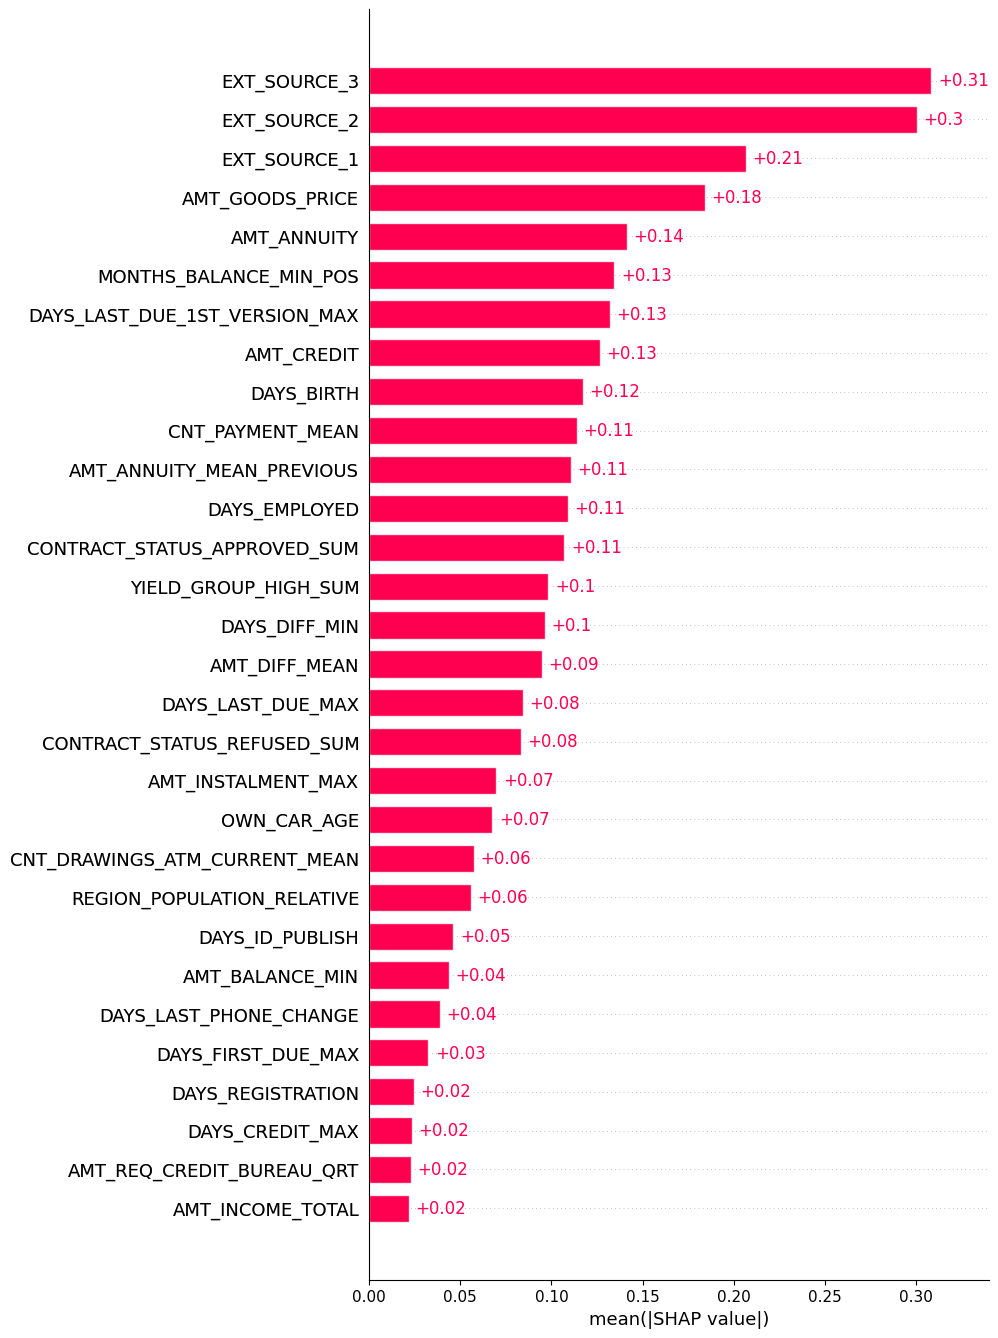

In [29]:
explainer = shap.Explainer(model_hyperparams)
shap_values = explainer(X_train[summary['selected_features_names']])
shap.plots.bar(shap_values, max_display=X_test.shape[0])
